In [15]:
import numpy as np
import pandas as pd
import zipfile
import io
data_path = "/Users/emrecavus/Desktop/CS445_Project/TRAIN_RELEASE_3SEP2025.zip"


In [16]:
# Load the zip file and read CSV files to extract column names
# We are going to be using the dataset from SemEval-2026 Task2
columns = {}

with zipfile.ZipFile(data_path, 'r') as z:
    all_files = z.namelist()

    csv_files = [
        f for f in all_files 
        if f.startswith('TRAIN_RELEASE_3SEP2025/') and f.endswith('.csv')
    ]

    for csv_file in csv_files:
        with z.open(csv_file) as f:
            df = pd.read_csv(f)
            columns[csv_file] = list(df.columns)



In [17]:
# Going with train_subtask1.csv, train_subtask2a.csv, train_subtask2b.csv first
def read_from_zip(zip_path, inner_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(inner_path) as f:
            return pd.read_csv(f)

df = read_from_zip(data_path, "TRAIN_RELEASE_3SEP2025/train_subtask1.csv")
test_set = read_from_zip(data_path, "TRAIN_RELEASE_3SEP2025/trial_data.csv")


In [18]:
# Checking the lengths of the dataframe
print(f"Length of DF: {len(df)}")
print(f"Length of Test Set: {len(test_set)}")


Length of DF: 2764
Length of Test Set: 60


In [19]:
# Checking how many unique users are there in the dataframe
df["user_id"].describe()


count    2764.000000
mean       75.847323
std        54.044222
min         1.000000
25%        33.000000
50%        63.000000
75%       124.000000
max       182.000000
Name: user_id, dtype: float64

In [20]:
df.head()


,user_id,text_id,text,timestamp,collection_phase,is_words,valence,arousal
0,3,251,I ' ve been feeling just fine . Nice and relax...,2021-06-08 12:26:16,1,False,1.0,1.0
1,3,252,I ' ve been feeling pretty good . This is my l...,2021-06-09 13:41:40,1,False,0.0,1.0
2,3,253,Still feeling sick today and sneezing alot wit...,2021-06-11 15:13:48,1,False,1.0,1.0
3,3,254,I ' m still feeling kinda sickly but I powered...,2021-06-12 12:20:03,1,False,1.0,1.0
4,3,255,I ' m feeling so much better today ! Seems lik...,2021-06-13 14:54:41,1,False,2.0,1.0


In [21]:
test_set.head()


,user_id,text_id,text,timestamp,collection_phase,is_words,valence,arousal,text_per_user
0,2,1,I am doing well . Getting ready for work . It ...,2022-01-22 11:03:16,2,False,0.0,0.0,11
1,2,2,I am feeling OK . A little anxious because I...,2022-01-22 16:22:38,2,False,0.0,1.0,11
2,2,3,I am feeling pretty good right now and only ge...,2022-01-22 20:32:50,2,False,1.0,1.0,11
3,2,4,At this very moment I am feeling very content ...,2022-01-23 15:08:37,2,False,1.0,1.0,11
4,2,5,I just got home from a very long day of work a...,2022-01-23 20:03:16,2,False,2.0,1.0,11


In [22]:
# Exploratory Data Analysis on Valence and Arousal Scores


In [23]:
df['valence'].describe()


count    2764.000000
mean        0.216715
std         1.292142
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: valence, dtype: float64

In [24]:
# Checking for nan values in state change in valence
df['valence'].isna().sum()


0

In [25]:
df['arousal'].describe()


count    2764.000000
mean        0.751085
std         0.753985
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: arousal, dtype: float64

In [26]:
# Checking for nan values in state change in arousal
df['arousal'].isna().sum()


0

In [27]:
test_set = test_set.drop(columns=['text_per_user'])


In [28]:
# Sorting the dataframe by user_id and timestamp to analyze valence and arousal changes over time
# But there is one issue, the first samples in the test set are likely to have their previous valence and arousal scores, and time related differences in the dataframe. 

# So first concatenating them with 'is_train' label, then seperating them according to that label
df['is_train'] = 1
test_set['is_train'] = 0

full_data = pd.concat([df, test_set], ignore_index=True)

full_data['timestamp'] = pd.to_datetime(full_data['timestamp'])
full_data = full_data.sort_values(['user_id', 'timestamp'])

full_data['prev_valence'] = full_data.groupby('user_id')['valence'].shift(1).fillna(0.0)
full_data['prev_arousal'] = full_data.groupby('user_id')['arousal'].shift(1).fillna(1.0)


full_data['time_diff'] = full_data.groupby('user_id')['timestamp'].diff().dt.total_seconds() / 3600
full_data['time_diff'] = full_data['time_diff'].fillna(24.0)
full_data['log_time_diff'] = np.log1p(full_data['time_diff'])

df = full_data[full_data['is_train'] == 1].copy()
test_set = full_data[full_data['is_train'] == 0].copy()

cols_to_drop = ['is_train', 'time_diff']
df = df.drop(columns=cols_to_drop)
test_set = test_set.drop(columns=cols_to_drop)



In [29]:
# Dropping the text id, and seeing a large sample from the dataset
df = df.drop(columns=['text_id'])
test_set = test_set.drop(columns=['text_id'])
df.head(15)


,user_id,text,timestamp,collection_phase,is_words,valence,arousal,prev_valence,prev_arousal,log_time_diff
2697,1,I feel good . I caught up on some sleep . Wo...,2021-06-09 12:41:57,1,False,2.0,1.0,0.0,1.0,3.218876
2698,1,I’ve been feeling good for days and days . I r...,2021-06-11 12:01:45,1,False,2.0,1.0,2.0,1.0,3.878052
2699,1,I’ve been feeling fine personally . I’ve been ...,2021-06-13 13:15:07,1,False,0.0,1.0,2.0,1.0,3.916469
2700,1,I feel great . I’ve had a day off . I’m going ...,2021-06-16 12:03:12,1,False,2.0,1.0,0.0,1.0,4.273904
2701,1,I feel great today . I am well rested . I have...,2021-06-17 12:38:38,1,False,2.0,2.0,2.0,1.0,3.242223
1521,2,"Productive , Tired , Active , Pleased , Busy",2021-06-08 15:11:55,1,True,0.0,2.0,0.0,1.0,3.218876
1522,2,"Productive , Busy , Content",2021-06-11 17:10:13,1,True,0.0,2.0,0.0,2.0,4.317110
1523,2,"Relaxed , Content , Comfy , Happy , Calm",2021-06-15 16:35:44,1,True,2.0,0.0,0.0,2.0,4.568768
1524,2,"Productive , Relaxed , Happy , Content",2021-06-18 15:36:22,1,True,2.0,1.0,2.0,0.0,4.276813
1525,2,"Relaxed , Rested , Happy , Pleased , Content",2022-02-11 12:51:15,2,True,2.0,0.0,2.0,1.0,5.340255


In [30]:
test_set.head()


,user_id,text,timestamp,collection_phase,is_words,valence,arousal,prev_valence,prev_arousal,log_time_diff
2764,2,I am doing well . Getting ready for work . It ...,2022-01-22 11:03:16,2,False,0.0,0.0,2.0,1.0,8.561870
2765,2,I am feeling OK . A little anxious because I...,2022-01-22 16:22:38,2,False,0.0,1.0,0.0,0.0,1.844159
2766,2,I am feeling pretty good right now and only ge...,2022-01-22 20:32:50,2,False,1.0,1.0,0.0,1.0,1.642873
2767,2,At this very moment I am feeling very content ...,2022-01-23 15:08:37,2,False,1.0,1.0,1.0,1.0,2.975345
2768,2,I just got home from a very long day of work a...,2022-01-23 20:03:16,2,False,2.0,1.0,1.0,1.0,1.776787


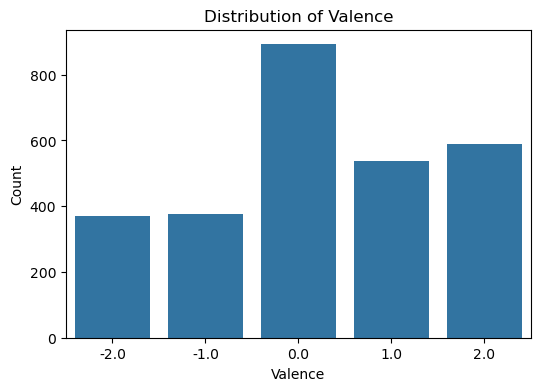

In [31]:
# Plotting the distribution of valence scores in the dataframe
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x=df['valence'], order=sorted(df['valence'].unique()))
plt.title("Distribution of Valence")
plt.xlabel("Valence")
plt.ylabel("Count")
plt.show()


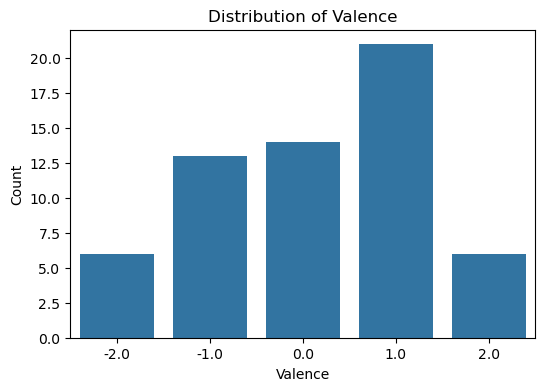

In [32]:
# Plotting the distribution of valence scores in the test set
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x=test_set['valence'], order=sorted(test_set['valence'].unique()))
plt.title("Distribution of Valence")
plt.xlabel("Valence")
plt.ylabel("Count")
plt.show()


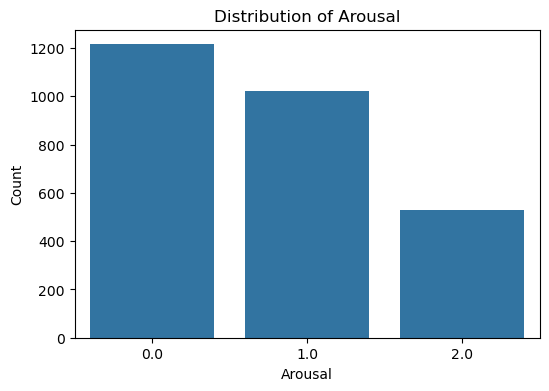

In [33]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['arousal'], order=sorted(df['arousal'].unique()))
plt.title("Distribution of Arousal")
plt.xlabel("Arousal")
plt.ylabel("Count")
plt.show()


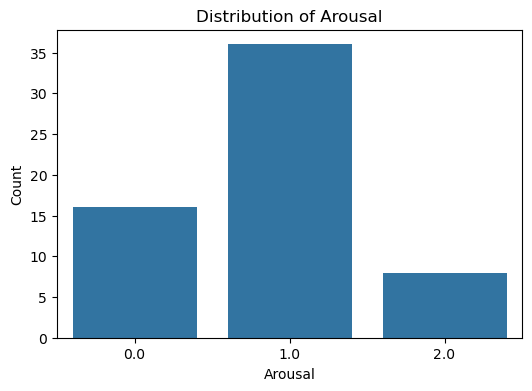

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(x=test_set['arousal'], order=sorted(test_set['arousal'].unique()))
plt.title("Distribution of Arousal")
plt.xlabel("Arousal")
plt.ylabel("Count")
plt.show()


Text(0.5, 1.0, 'Mean Valence per User')

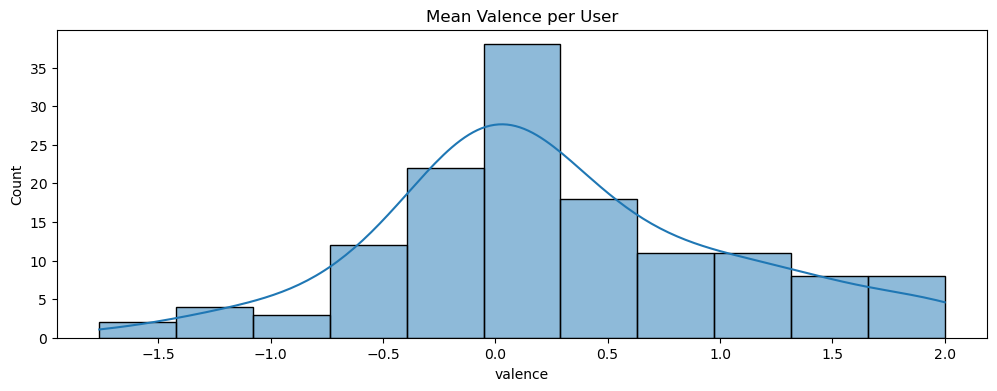

In [35]:
# Analyzing valence per user
user_stats = df.groupby("user_id")[["valence"]].mean()

fig, ax = plt.subplots(1, 1, figsize=(12,4))

sns.histplot(user_stats['valence'], kde=True, ax=ax)
ax.set_title("Mean Valence per User")


Text(0.5, 1.0, 'Mean Arousal per User')

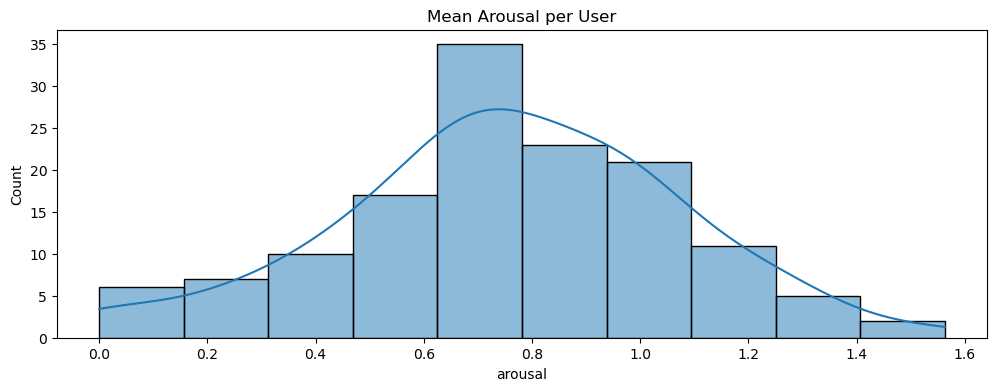

In [36]:
# Analyzing arousal per user
user_stats = df.groupby("user_id")[["arousal"]].mean()

fig, ax = plt.subplots(1, 1, figsize=(12,4))

sns.histplot(user_stats['arousal'], kde=True, ax=ax)
ax.set_title("Mean Arousal per User")


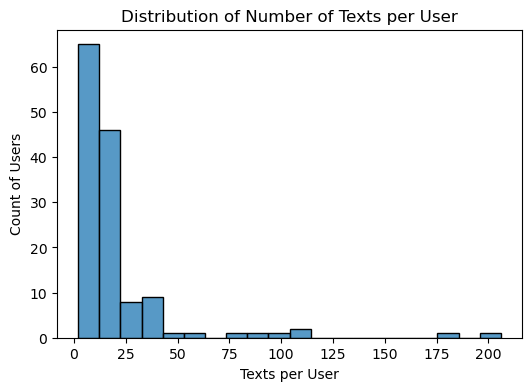

In [37]:
# The number of texts per user, might give an insight about the valence and arousal levels
texts_per_user = df['user_id'].value_counts()

plt.figure(figsize=(6,4))
sns.histplot(texts_per_user, bins=20, kde=False)
plt.title("Distribution of Number of Texts per User")
plt.xlabel("Texts per User")
plt.ylabel("Count of Users")
plt.show()


<Axes: xlabel='collection_phase', ylabel='valence'>

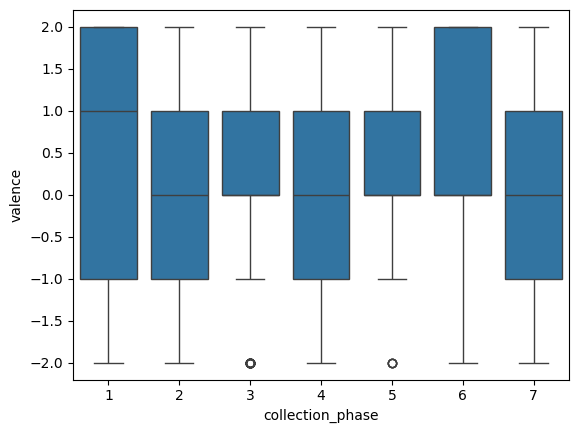

In [38]:
# Distributions of valence among the collection phase
sns.boxplot(x='collection_phase', y='valence', data=df)


<Axes: xlabel='collection_phase', ylabel='arousal'>

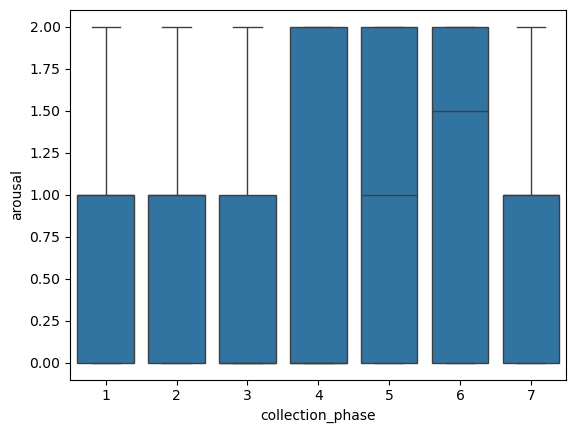

In [39]:
# Distributions of arousal among the collection phase
sns.boxplot(x='collection_phase', y='arousal', data=df)


<Axes: xlabel='is_words', ylabel='valence'>

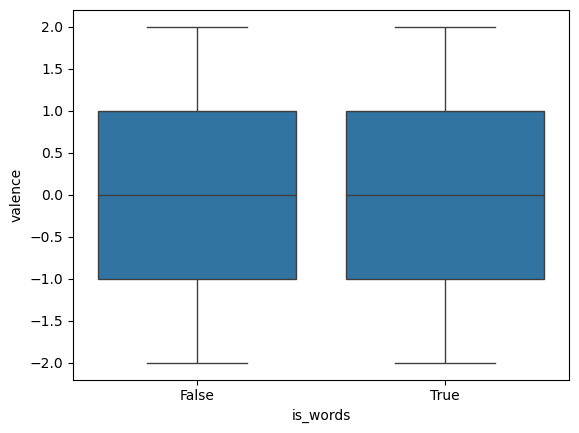

In [40]:
# Distributions of valence among the essays and feeling words
sns.boxplot(x='is_words', y='valence', data=df)


<Axes: xlabel='is_words', ylabel='valence'>

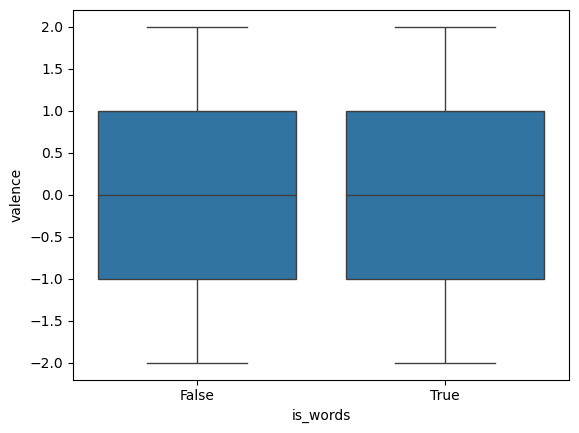

In [41]:
# Distributions of arousal among the essays and feeling words
sns.boxplot(x='is_words', y='valence', data=df)


In [42]:
# Analyzing the timestamp to see the time effects
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.dayofweek

# Applying the same to test set
test_set['timestamp'] = pd.to_datetime(test_set['timestamp'])
test_set['hour'] = test_set['timestamp'].dt.hour
test_set['weekday'] = test_set['timestamp'].dt.dayofweek



<Axes: xlabel='hour', ylabel='valence'>

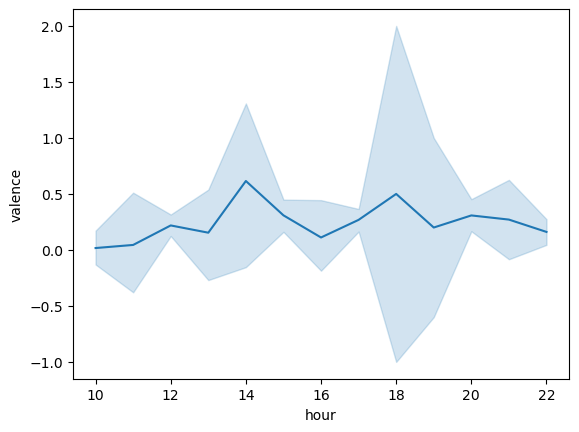

In [43]:
# Seeing how valence levels change with hour ıf the day
sns.lineplot(x='hour', y='valence', data=df)


<Axes: xlabel='hour', ylabel='arousal'>

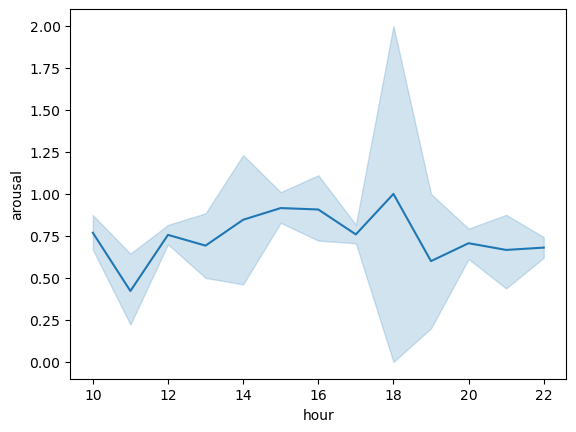

In [44]:
# Seeing how valence levels change with hour ıf the day
sns.lineplot(x='hour', y='arousal', data=df)


<Axes: xlabel='weekday', ylabel='valence'>

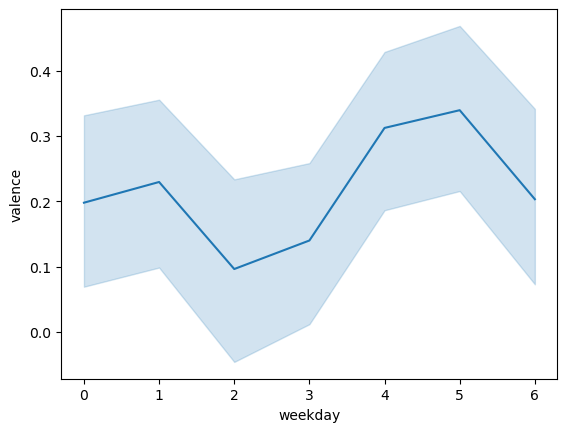

In [45]:
# Inspecting the relationship between weekday and valence
sns.lineplot(x='weekday', y='valence', data=df)


<Axes: xlabel='weekday', ylabel='arousal'>

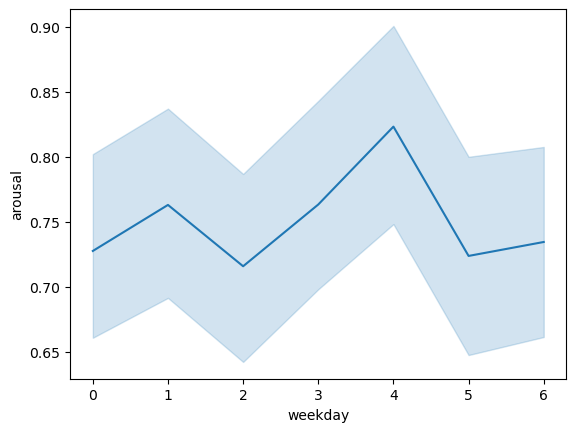

In [46]:
# Inspecting the relationship between weekday and valence
sns.lineplot(x='weekday', y='arousal', data=df)


<Axes: xlabel='text_len', ylabel='valence'>

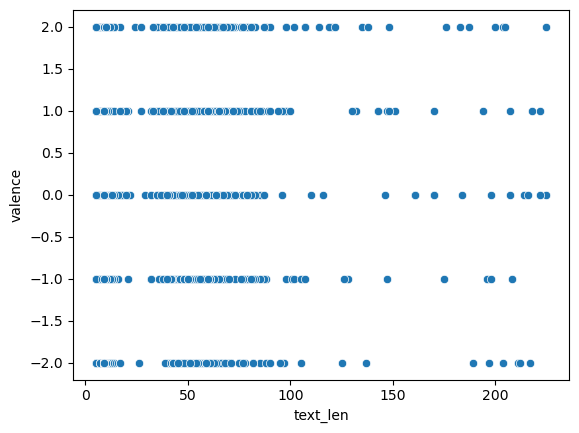

In [47]:
# Adding text length as a feature
# Inspecting the relationship between text length and valence
df['text_len'] = df['text'].str.split().str.len()
sns.scatterplot(x='text_len', y='valence', data=df)


<Axes: xlabel='text_len', ylabel='valence'>

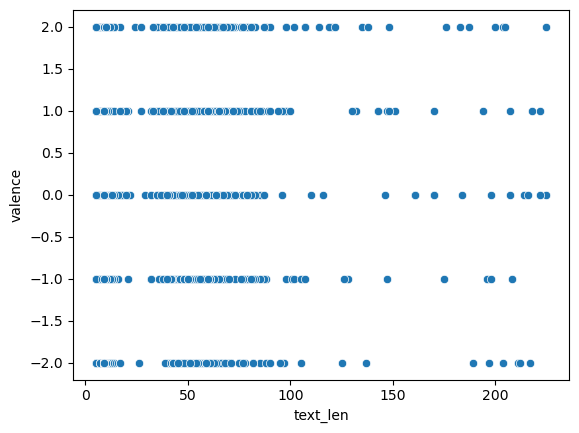

In [48]:
# Adding text length as a feature
# Inspecting the relationship between text length and valence
df['text_len'] = df['text'].str.split().str.len()
sns.scatterplot(x='text_len', y='valence', data=df)


<Axes: xlabel='lex_sent', ylabel='valence'>

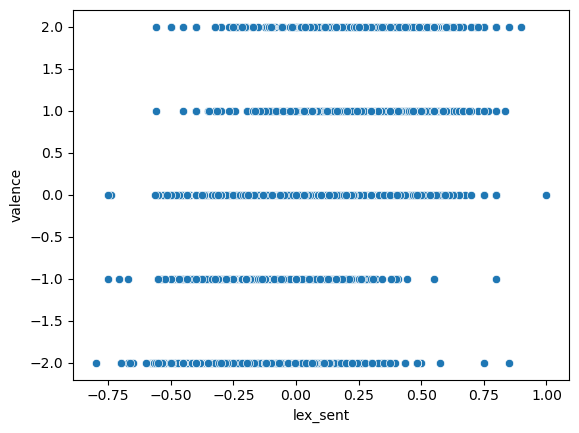

In [49]:
# Sentiment lexicon analysis
# Inspecting the relationship between sentiment lexicons and valence
from textblob import TextBlob
df['lex_sent'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sns.scatterplot(x='lex_sent', y='valence', data=df)


<Axes: xlabel='lex_sent', ylabel='arousal'>

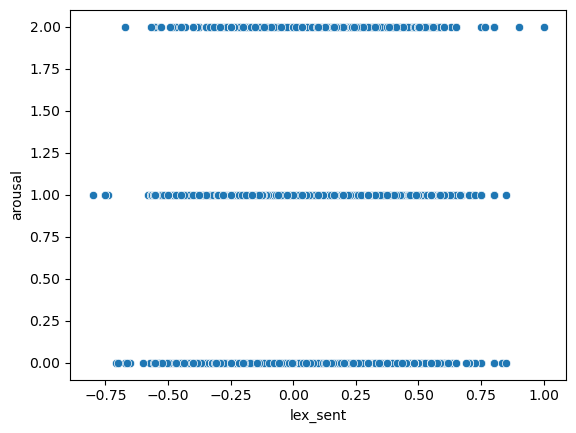

In [50]:
# Sentiment lexicon analysis
# Inspecting the relationship between sentiment lexicons and arousal
from textblob import TextBlob
df['lex_sent'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sns.scatterplot(x='lex_sent', y='arousal', data=df)


In [51]:
df.head()


,user_id,text,timestamp,collection_phase,is_words,valence,arousal,prev_valence,prev_arousal,log_time_diff,hour,weekday,text_len,lex_sent
2697,1,I feel good . I caught up on some sleep . Wo...,2021-06-09 12:41:57,1,False,2.0,1.0,0.0,1.0,3.218876,12,2,45,0.362500
2698,1,I’ve been feeling good for days and days . I r...,2021-06-11 12:01:45,1,False,2.0,1.0,2.0,1.0,3.878052,12,4,46,0.213750
2699,1,I’ve been feeling fine personally . I’ve been ...,2021-06-13 13:15:07,1,False,0.0,1.0,2.0,1.0,3.916469,13,6,62,0.127462
2700,1,I feel great . I’ve had a day off . I’m going ...,2021-06-16 12:03:12,1,False,2.0,1.0,0.0,1.0,4.273904,12,2,66,0.462500
2701,1,I feel great today . I am well rested . I have...,2021-06-17 12:38:38,1,False,2.0,2.0,2.0,1.0,3.242223,12,3,51,0.462597


In [52]:
# Excluding columns that have small relevance to prediction of state change valence
df = df.drop(columns=['is_words', 'text_len', 'lex_sent'])
test_set = test_set.drop(columns=['is_words'])


In [53]:
# One hot encoding collection phase
df = pd.get_dummies(
    df,
    columns=['collection_phase'],
    prefix='phase',
    drop_first=False
)

test_set = pd.get_dummies(
    test_set,
    columns=['collection_phase'],
    prefix='phase',
    drop_first=False
)


In [54]:
import numpy as np

# We're going to be cyclical encoding hour, as it's not a continuous variable
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

test_set['hour_sin'] = np.sin(2 * np.pi * test_set['hour'] / 24)
test_set['hour_cos'] = np.cos(2 * np.pi * test_set['hour'] / 24)
df = df.drop(columns=['hour'])
test_set = test_set.drop(columns=['hour'])

# One-hot encoding weekday -> again, not continuous
df = pd.get_dummies(
    df,
    columns=['weekday'],
    prefix='weekday',
    drop_first=False
)

test_set = pd.get_dummies(
    test_set,
    columns=['weekday'],
    prefix='weekday',
    drop_first=False
)


In [55]:
# The time difference from the last post may be a great indicator for valence / arousal
# Higher time pass most likely result in neutralized valence and arousal levels

df['time_diff'] = df.groupby('user_id')['timestamp'].diff().dt.total_seconds() / 3600


df['time_diff'] = df['time_diff'].fillna(24.0)

# Taking log transform of it because time gaps can be huge (skewed distribution)
df['log_time_diff'] = np.log1p(df['time_diff'])


test_set['time_diff'] = test_set.groupby('user_id')['timestamp'].diff().dt.total_seconds() / 3600


test_set['time_diff'] = test_set['time_diff'].fillna(24.0)

# Taking log transform of it because time gaps can be huge (skewed distribution)
test_set['log_time_diff'] = np.log1p(test_set['time_diff'])


df = df.drop(columns=['time_diff'])
test_set = test_set.drop(columns=['time_diff'])


In [56]:
df.columns


Index(['user_id', 'text', 'timestamp', 'valence', 'arousal', 'prev_valence',
       'prev_arousal', 'log_time_diff', 'phase_1', 'phase_2', 'phase_3',
       'phase_4', 'phase_5', 'phase_6', 'phase_7', 'hour_sin', 'hour_cos',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6'],
      dtype='object')

In [57]:
test_set.columns


Index(['user_id', 'text', 'timestamp', 'valence', 'arousal', 'prev_valence',
       'prev_arousal', 'log_time_diff', 'phase_1', 'phase_2', 'hour_sin',
       'hour_cos', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

Pearson Correlation: 0.0264
Spearman Correlation: 0.0165


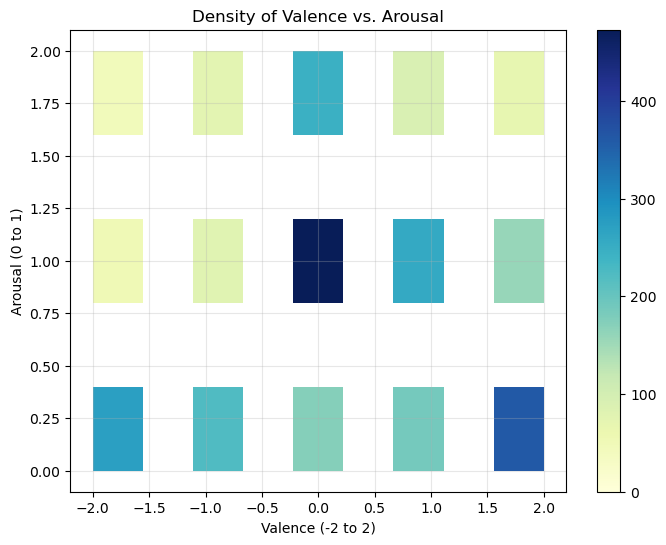

In [58]:
# 1. Calculating Pearson and Spearman correlations between valence and arousal
pearson_corr = df['valence'].corr(df['arousal'], method='pearson')
spearman_corr = df['valence'].corr(df['arousal'], method='spearman')

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

# Since the data is discrete, a standard scatter plot often has too much overlap.
# A heatmap shows the density of samples in the 2D Emotion Space.

plt.figure(figsize=(8, 6))
sns.histplot(x=df['valence'], y=df['arousal'], 
             bins=(9, 5), cmap="YlGnBu", cbar=True)
plt.title("Density of Valence vs. Arousal")
plt.xlabel("Valence (-2 to 2)")
plt.ylabel("Arousal (0 to 1)")
plt.grid(alpha=0.3)
plt.show()


In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

# For arousal prediction, we're using Sentiment Intensity Analyzer
def get_vader_score(text):
    return analyzer.polarity_scores(str(text))['compound']

# Vader scores might be a great indicator of arousal scores
df['vader_score'] = df['text'].apply(get_vader_score)
test_set['vader_score'] = test_set['text'].apply(get_vader_score)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/emrecavus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [60]:
# Adding log word count, because usually longer words have more state changes and needs further investigation
df['log_word_count'] = df['text'].apply(lambda x: np.log1p(len(str(x).split())))
test_set['log_word_count'] = test_set['text'].apply(lambda x: np.log1p(len(str(x).split())))


In [61]:
def get_caps_ratio(text):
    # Calculating the percentage of capitals in a text, as it is correlated with high arousal
    if not isinstance(text, str) or len(text) == 0:
        return 0.0
    
    n_caps = sum(1 for c in text if c.isupper())
    n_alpha = sum(1 for c in text if c.isalpha())
    
    if n_alpha == 0:
        return 0.0
        
    return n_caps / n_alpha

df['caps_ratio'] = df['text'].apply(get_caps_ratio)
test_set['caps_ratio'] = test_set['text'].apply(get_caps_ratio)
# Exclamation marks are the other great indicators of high arousal
df['exclamation_count'] = df['text'].apply(lambda x: str(x).count('!'))
test_set['exclamation_count'] = test_set['text'].apply(lambda x: str(x).count('!'))


In [62]:
df.columns


Index(['user_id', 'text', 'timestamp', 'valence', 'arousal', 'prev_valence',
       'prev_arousal', 'log_time_diff', 'phase_1', 'phase_2', 'phase_3',
       'phase_4', 'phase_5', 'phase_6', 'phase_7', 'hour_sin', 'hour_cos',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'vader_score', 'log_word_count', 'caps_ratio',
       'exclamation_count'],
      dtype='object')

In [63]:
test_set.columns


Index(['user_id', 'text', 'timestamp', 'valence', 'arousal', 'prev_valence',
       'prev_arousal', 'log_time_diff', 'phase_1', 'phase_2', 'hour_sin',
       'hour_cos', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'vader_score', 'log_word_count',
       'caps_ratio', 'exclamation_count'],
      dtype='object')

In [64]:
# Starting to split our data into train, validation and test sets
users = df['user_id'].unique()
# Setting a constant random state to split the dataset the same way in each run
np.random.seed(42)
np.random.shuffle(users)


In [65]:
# Seperating them by user id's
n = len(users)

# As we have 2700 samples, the split will be 0.8/0.1/0.1. 
# We need to feed the training data as much as we can

train_users = users[:int(0.8 * n)]
val_users   = users[int(0.8 * n):]


In [66]:
train_df = df[df['user_id'].isin(train_users)]
val_df   = df[df['user_id'].isin(val_users)]


In [67]:
# Sepeating into X and y
X_train = train_df.drop(columns=['valence', 'arousal'])
y_train = train_df[['valence', 'arousal']]

X_val = val_df.drop(columns=['valence', 'arousal'])
y_val = val_df[['valence', 'arousal']]

X_test = test_set.drop(columns=['valence', 'arousal'])
y_test = test_set[['valence', 'arousal']]


In [68]:
# Phases 3 to 6 were missing in the test_set, so adding those dummies
train_cols = X_train.columns
X_test = X_test.reindex(columns=train_cols, fill_value=0)
print(f"Train columns: {len(X_train.columns)}")
print(f"Test columns:  {len(X_test.columns)}")
assert list(X_train.columns) == list(X_test.columns)


Train columns: 26
Test columns:  26


In [69]:
# Ensuring no user overlap between sets
assert set(train_users).isdisjoint(val_users)


In [70]:
# Seeing the distribution of target variable in training set
y_train["valence"].value_counts().sort_index()


valence
-2.0    248
-1.0    262
 0.0    748
 1.0    408
 2.0    419
Name: count, dtype: int64

In [71]:
y_train["arousal"].value_counts().sort_index()


arousal
0.0    840
1.0    831
2.0    414
Name: count, dtype: int64

In [72]:
# in validation set
y_val["valence"].value_counts().sort_index()


valence
-2.0    121
-1.0    115
 0.0    144
 1.0    130
 2.0    169
Name: count, dtype: int64

In [73]:
y_val["arousal"].value_counts().sort_index()


arousal
0.0    375
1.0    191
2.0    113
Name: count, dtype: int64

In [74]:
# in test set
y_test["valence"].value_counts().sort_index()


valence
-2.0     6
-1.0    13
 0.0    14
 1.0    21
 2.0     6
Name: count, dtype: int64

In [75]:
y_test["arousal"].value_counts().sort_index()


arousal
0.0    16
1.0    36
2.0     8
Name: count, dtype: int64

In [76]:
# Text cleaning pipeline for RoBERTa embedding
import re

# Converting emoticons into text
EMOTICON_PATTERNS = [
    (r"(?::|=)\s?-?\s?\)", " <SMILE> "),
    (r"(?::|=)\s?-?\s?\(", " <SAD> "),
    (r";\s?-?\s?\)",       " <WINK> "),
    (r"(?::|=)\s?-?\s?D",  " <LAUGH> "),
    (r"<\s?3",             " <LOVE> "),
]

# Removing extra whitespace, repeated punctuation and control characters
_whitespace_re = re.compile(r"\s+")
_repeated_punct_re = re.compile(r"([!?.,])\1{2,}")   
_repeated_char_re = re.compile(r"(.)\1{4,}")        
_control_chars_re = re.compile(r"[\u0000-\u001F\u007F-\u009F]+")


In [77]:
# Function to replace emoticons with text
def replace_emoticons(text: str) -> str:
    for pat, repl in EMOTICON_PATTERNS:
        text = re.sub(pat, repl, text)
    return text

# Checking if emoji library is installed
# If yes, then we will be replacing emojis with text
try:
    import emoji
    HAS_EMOJI = True
except ImportError:
    HAS_EMOJI = False
def demojize_text(text: str) -> str:
    if not HAS_EMOJI:
        return text
    # Using whitespace delimiters to avoid colon-heavy tokens like :smile:
    text = emoji.demojize(text, delimiters=(" ", " "))
    # Turning underscores into spaces for readability
    text = text.replace("_", " ")
    return text



In [78]:
# Applying the text cleaning pipeline
def clean_text_for_roberta(
    text: str,
    *,
    do_lowercase: bool = False,  
    convert_emojis: bool = True,
    convert_emoticons: bool = True,
    normalize_repeats: bool = True
) -> str:
    
    if text is None:
        return ""

    # Basic normalization
    text = str(text).strip()
    text = _control_chars_re.sub(" ", text)

    # We're going to be adding emoticon + emoji normalization
    if convert_emoticons:
        text = replace_emoticons(text)
    if convert_emojis:
        text = demojize_text(text)

    # Normalizing extreme repetitions 
    if normalize_repeats:
        text = _repeated_punct_re.sub(r"\1", text)  
        text = _repeated_char_re.sub(r"\1\1\1", text) 

    # Whitespace cleanup
    text = _whitespace_re.sub(" ", text).strip()

    # We will be using RoBERTa model, so lowercasing is usually not recommended for RoBERTa
    if do_lowercase:
        text = text.lower()

    return text


In [79]:
# Applying RoBERTa-friendly cleaning to the text column
X_train["text_clean"] = X_train["text"].apply(clean_text_for_roberta)
X_val["text_clean"]   = X_val["text"].apply(clean_text_for_roberta)
X_test["text_clean"]  = X_test["text"].apply(clean_text_for_roberta)



In [80]:
X_train.drop(columns=['text'], inplace=True)
X_val.drop(columns=['text'], inplace=True)
X_test.drop(columns=['text'], inplace=True)
X_train.head()



,user_id,timestamp,prev_valence,prev_arousal,log_time_diff,phase_1,phase_2,phase_3,phase_4,phase_5,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,vader_score,log_word_count,caps_ratio,exclamation_count,text_clean
2697,1,2021-06-09 12:41:57,0.0,1.0,3.218876,True,False,False,False,False,...,True,False,False,False,False,0.7374,3.828641,0.038462,0,I feel good . I caught up on some sleep . Work...
2698,1,2021-06-11 12:01:45,2.0,1.0,3.878052,True,False,False,False,False,...,False,False,True,False,False,0.6679,3.850148,0.045161,3,I’ve been feeling good for days and days . I r...
2699,1,2021-06-13 13:15:07,2.0,1.0,3.916469,True,False,False,False,False,...,False,False,False,False,True,-0.5913,4.143135,0.019084,0,I’ve been feeling fine personally . I’ve been ...
2700,1,2021-06-16 12:03:12,0.0,1.0,4.273904,True,False,False,False,False,...,True,False,False,False,False,0.8982,4.204693,0.048544,0,I feel great . I’ve had a day off . I’m going ...
2701,1,2021-06-17 12:38:38,2.0,1.0,3.242223,True,False,False,False,False,...,False,True,False,False,False,0.9623,3.951244,0.035928,0,I feel great today . I am well rested . I have...


In [81]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel


# We exclude 'user_id', 'timestamp', and 'text_clean' from this list, the remaining will be the features we will feed into the model
feature_cols = [col for col in X_train.columns if col not in ['user_id', 'timestamp', 'text_clean']]
print(f"Using {len(feature_cols)} numerical features: {feature_cols}")

class EcologicalDataset(Dataset):
    def __init__(self, X_df, y_df, tokenizer, max_len=256, feature_cols=None):
        self.texts = X_df['text_clean'].tolist()
        # Extracting numerical features as a float tensor
        self.features = X_df[feature_cols].values.astype('float32') if feature_cols else None
        # Our targets will be Valence and Arousal
        self.targets = y_df.values.astype('float32')
        
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        target = self.targets[idx]
        feats = self.features[idx]

        # We will be using RoBERTa encoding
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'numerical_features': torch.tensor(feats, dtype=torch.float),
            'targets': torch.tensor(target, dtype=torch.float)
        }

# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Creating datasets with our features + RoBERTa tokenizer
train_dataset = EcologicalDataset(X_train, y_train, tokenizer, feature_cols=feature_cols)
val_dataset = EcologicalDataset(X_val, y_val, tokenizer, feature_cols=feature_cols)
test_dataset = EcologicalDataset(X_test, y_test, tokenizer, feature_cols=feature_cols)

# Creating data loaders to be feeded into the model
BATCH_SIZE = 16 
# Small batch size for stability on small data + memory requirements
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


Using 23 numerical features: ['prev_valence', 'prev_arousal', 'log_time_diff', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_5', 'phase_6', 'phase_7', 'hour_sin', 'hour_cos', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'vader_score', 'log_word_count', 'caps_ratio', 'exclamation_count']


In [82]:
import torch.nn as nn

# As we will be doing an Ordinal Classification, training a regression head with CNN + converting them to classes will be our approach
class RobertaCNNOrdinal(nn.Module):
    def __init__(self, n_numerical_features):
        super(RobertaCNNOrdinal, self).__init__()
        
        # Creating the RoBERTa backbone
        self.roberta = AutoModel.from_pretrained('roberta-base')
        
        # In the paper by Naacl, they used filters [1024, 2048], but that's huge for 2.7k samples. They trained on millions of samples
        # We will be adding layers for all bigram, trigram, and 4-grams. 
        self.conv_2 = nn.Conv1d(768, 64, kernel_size=2, padding=1)
        self.conv_3 = nn.Conv1d(768, 64, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv1d(768, 64, kernel_size=4, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1) 
        # Will be using MaxPool
        
        # Applying batch normalization on the numerical features
        self.num_bn = nn.BatchNorm1d(n_numerical_features)
        # Fusion Layer (Combines Text Embeddings + Numerical features)
        # 192 comes from conv 2,3,4 => 3*64
        combined_dim = 192 + n_numerical_features
        
        # Regressors (Ordinal Heads)
        # Head for Valence Change
        self.valence_head = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),           
            nn.Dropout(0.2), 
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 1)
        )
        
        # Head for Arousal Change
        self.arousal_head = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),           
            nn.Dropout(0.4), 
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 1)
        )

    def forward(self, input_ids, attention_mask, numerical_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state.permute(0, 2, 1)
            

        # We apply 3 different filters and pool them separately
        c2 = self.pool(self.relu(self.conv_2(x))).squeeze(2)
        c3 = self.pool(self.relu(self.conv_3(x))).squeeze(2)
        c4 = self.pool(self.relu(self.conv_4(x))).squeeze(2)
        
        # Concatenating CNN outputs with the total dimension of 192
        cnn_out = torch.cat([c2, c3, c4], dim=1)
        
        num_feats = self.num_bn(numerical_features)
        
        # Final Fusion
        combined = torch.cat((cnn_out, num_feats), dim=1)
        
        return self.valence_head(combined), self.arousal_head(combined)

model = RobertaCNNOrdinal(n_numerical_features=len(feature_cols))

# After initializing the model, we're setting up the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model created and moved to {device}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model created and moved to mps


In [83]:
# Small check to see everything is correct
batch = next(iter(train_loader))
ids = batch['input_ids'].to(device)
mask = batch['attention_mask'].to(device)
num_feats = batch['numerical_features'].to(device)

v_out, a_out = model(ids, mask, num_feats)
print(f"Output shapes: Valence {v_out.shape}, Arousal {a_out.shape}") 


Output shapes: Valence torch.Size([16, 1]), Arousal torch.Size([16, 1])


In [84]:
import torch.optim as optim
import copy
import numpy as np
from tqdm import tqdm

def calculate_dampened_weights(y_data, possible_values, power=0.5):
    # Our data is nor balanced, biased towards the center class
    # Hence, we can arrange the power parameter to weigh the MSEs that were made
    counts = y_data.value_counts().sort_index()
    
    # 2. Dampened Inverse Frequency: 1 / (count^power)
    # power=1.0 is your current method (too aggressive)
    # power=0.5 is Square Root (balanced)
    # power=0.0 is No Weighting
    weights = 1.0 / np.power(counts + 1, power) 
    
    # Normalizing and mapping the weights
    weights = weights / weights.mean()
    
    weight_map = {val: w for val, w in zip(counts.index, weights)}
    max_w = weights.max()
    return {k: weight_map.get(k, max_w) for k in possible_values}

# Mapping the weights for both valence and arousal classes
val_weights_map = calculate_dampened_weights(y_train['valence'], np.arange(-2, 3), power=0.5)
aro_weights_map = calculate_dampened_weights(y_train['arousal'], np.arange(0, 3), power=0.5)

print("New Valence Weights:", val_weights_map)

import torch.nn.functional as F

def weighted_mse_loss(input, target, weight_map):
    # As we have a regression head in our CNN, we are going to be using MSE. 
    # Integrating the weight map created in the previous function
    target_class = torch.round(target).long()
    
    
    weights = torch.tensor([weight_map.get(int(t.item()), 1.0) for t in target_class]).to(input.device).view(-1, 1)
    
    loss = (input - target) ** 2
    
    return (loss * weights).mean()


from transformers import get_linear_schedule_with_warmup


New Valence Weights: {-2: 1.219563122382111, -1: 1.1866593973503403, 0: 0.7031743950486048, 1: 0.951573421202581, 2: 0.9390296640163625}


In [85]:
from torch.utils.data import WeightedRandomSampler

def get_weighted_sampler(y_train_df):
    
    # As our dataset is imbalanced, we will be creating a sampler that forces the DataLoader to pick rare classes more often.
    target = y_train_df['valence'].values
    class_counts = y_train_df['valence'].value_counts().sort_index()
    
    # Rare class = High weight
    class_weights = 1.0 / class_counts
    
    # Assigning a weight to EVERY sample in the dataset
    sample_weights = [class_weights[t] for t in target]
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    return sampler


In [86]:
def train_model_weighted(model, train_loader, val_loader, n_epochs=20, learning_rate=7.5e-5, patience=3):
    """
    This is the full training loop with Early Stopping, Weighted MSE Loss, and LR Scheduler.
    """
    
    # Optimizer Setup, we will be using differential learning rates
    # Assigning each layer of the CNN a sepeate learning rate
    optimizer = optim.AdamW([
            # Backbone Learning Rate
            {'params': model.roberta.parameters(), 'lr': 2e-5}, 
            
            # Regression Heads
            {'params': model.valence_head.parameters(), 'lr': learning_rate},
            {'params': model.arousal_head.parameters(), 'lr': learning_rate},
            
            # Multi-Scale CNN Layers
            {'params': model.conv_2.parameters(), 'lr': learning_rate},
            {'params': model.conv_3.parameters(), 'lr': learning_rate},
            {'params': model.conv_4.parameters(), 'lr': learning_rate},
            
            # Batch Normalization Layer
            {'params': model.num_bn.parameters(), 'lr': learning_rate}
            
        ], weight_decay=0.01)


    # Calculating total training steps
    total_steps = len(train_loader) * n_epochs
    
    # Creating a scheduler: 10% warmup, then linear decay
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps), 
        num_training_steps=total_steps
    )

    # Tracking the training and validation loss
    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    trigger_times = 0
    history = {'train_loss': [], 'val_loss': []}
    
    print(f"Starting training with Scheduler (Total Steps: {total_steps})...")

    for epoch in range(n_epochs):
        print(f'\nEpoch {epoch+1}/{n_epochs}')
        print('-' * 10)
        

        # We're unfreezing the RoBERTa layer at epoch 4. 
        if epoch < 4: 
            # print("Status: RoBERTa Frozen")
            for param in model.roberta.parameters(): param.requires_grad = False
        else:
            # print("Status: RoBERTa Unfrozen")
            for param in model.roberta.parameters(): param.requires_grad = True

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            
            loop = tqdm(dataloader, desc=phase, leave=False)
            
            # So bacially after each guess, it calculates the weighted MSE and adjusts the parameters
            for batch in loop:
                input_ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                num_feats = batch['numerical_features'].to(device)
                targets = batch['targets'].to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    pred_val, pred_aro = model(input_ids, mask, num_feats)
                    
                    
                    loss_v = weighted_mse_loss(pred_val, targets[:, 0].unsqueeze(1), val_weights_map)
                    loss_a = weighted_mse_loss(pred_aro, targets[:, 1].unsqueeze(1), aro_weights_map)
                    loss = loss_v + loss_a

                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
                        optimizer.step()
                        
                        # Step the scheduler AFTER the optimizer
                        scheduler.step()

                running_loss += loss.item() * input_ids.size(0)
                loop.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            print(f"{phase} Loss: {epoch_loss:.4f}")

            # If the validation loss doesn't become less than the best loss for 3 epochs, early stopping
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_model_weighted.pth')
                    print(f"--> New Best Model Saved! (Loss: {best_loss:.4f})")
                    trigger_times = 0 
                else:
                    trigger_times += 1
                    print(f"--> No Improvement. Patience: {trigger_times}/{patience}")
                    if trigger_times >= patience:
                        print(f"\nEarly stopping triggered at Epoch {epoch+1}!")
                        model.load_state_dict(best_model_wts)
                        return model, history

    print('\nTraining complete.')
    model.load_state_dict(best_model_wts)
    return model, history



In [87]:
import gc
def clean_memory(vars_to_delete=None):

    # Cleaning the memory to avoid exhaustive memory usage
    if vars_to_delete:
        for var_name in vars_to_delete:
            if var_name in globals():
                del globals()[var_name]
                print(f"Deleted: {var_name}")
    

    gc.collect()
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    

    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
        torch.mps.synchronize() 

    print("Memory cleanup completed.")


In [88]:
# We will be using cross validation with 5 folds
from sklearn.model_selection import KFold
# Merging Train and Validation for CV, we want to use as much data as possible
X_full = pd.concat([X_train, X_val]).reset_index(drop=True)
y_full = pd.concat([y_train, y_val]).reset_index(drop=True)


kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"Starting 5-Fold Cross Validation on {len(X_full)} samples...")

# We will be storing validation scores for each fold to see stability
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_full)):
    print(f"\n{'='*20}\nFOLD {fold+1}/5\n{'='*20}")
    
    # First we will be slicing the data for CV.
    X_train_fold = X_full.iloc[train_idx]
    y_train_fold = y_full.iloc[train_idx]

    train_sampler = get_weighted_sampler(y_train_fold)
    
    X_val_fold = X_full.iloc[val_idx]
    y_val_fold = y_full.iloc[val_idx]
    
    # Creating Datasets & Loaders
    train_ds = EcologicalDataset(X_train_fold, y_train_fold, tokenizer, max_len=256, feature_cols=feature_cols)
    val_ds = EcologicalDataset(X_val_fold, y_val_fold, tokenizer, max_len=256, feature_cols=feature_cols)
    
    # We are going to be using weighted sampler to not avoid extreme classes
    train_ld = DataLoader(
        train_ds, 
        batch_size=16, 
        sampler=train_sampler,
        shuffle=False          
    )
    val_ld = DataLoader(val_ds, batch_size=16)
    
    # c. Initializing new Model, resetting weights
    model = RobertaCNNOrdinal(n_numerical_features=len(feature_cols)).to(device)
    

    # We're going to be training 10 epochs at each fold, with the given hyperparameters
    trained_model, history = train_model_weighted(
        model, 
        train_ld, 
        val_ld, 
        n_epochs=10,  
        learning_rate=7.5e-5, 
        patience=3
    )
    
    torch.save(trained_model.state_dict(), f"roberta_ensemble_fold_{fold+1}.pth")
    
    # Recording the best validation loss score 
    best_val_loss = min(history['val_loss'])
    fold_scores.append(best_val_loss)
    print(f"Fold {fold+1} Best Val Loss: {best_val_loss:.4f}")

    
    clean_memory(['model', 'trained_model', 'history']) 
    
    print(f"Fold {fold+1} Complete & Memory Cleaned.\n")

print(f"\nCV Complete. Average Val Loss: {np.mean(fold_scores):.4f}")


Starting 5-Fold Cross Validation on 2764 samples...

FOLD 1/5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Starting training with Scheduler (Total Steps: 1390)...

Epoch 1/10
----------


train Loss: 2.9030


val Loss: 2.3273
--> New Best Model Saved! (Loss: 2.3273)

Epoch 2/10
----------


train Loss: 2.1857


val Loss: 1.7907
--> New Best Model Saved! (Loss: 1.7907)

Epoch 3/10
----------


train Loss: 1.7579


val Loss: 1.6006
--> New Best Model Saved! (Loss: 1.6006)

Epoch 4/10
----------


train Loss: 1.6542


val Loss: 1.5055
--> New Best Model Saved! (Loss: 1.5055)

Epoch 5/10
----------


train Loss: 1.3000


val Loss: 1.5106
--> No Improvement. Patience: 1/3

Epoch 6/10
----------


train Loss: 1.1666


val Loss: 1.3001
--> New Best Model Saved! (Loss: 1.3001)

Epoch 7/10
----------


train Loss: 1.0477


val Loss: 1.3347
--> No Improvement. Patience: 1/3

Epoch 8/10
----------


train Loss: 0.8915


val Loss: 1.3041
--> No Improvement. Patience: 2/3

Epoch 9/10
----------


train Loss: 0.9011


val Loss: 1.2897
--> New Best Model Saved! (Loss: 1.2897)

Epoch 10/10
----------


train Loss: 0.7863


val Loss: 1.2796
--> New Best Model Saved! (Loss: 1.2796)

Training complete.
Fold 1 Best Val Loss: 1.2796
Deleted: model
Deleted: trained_model
Deleted: history
Memory cleanup completed.
Fold 1 Complete & Memory Cleaned.


FOLD 2/5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with Scheduler (Total Steps: 1390)...

Epoch 1/10
----------


train Loss: 3.3554


val Loss: 2.5547
--> New Best Model Saved! (Loss: 2.5547)

Epoch 2/10
----------


train Loss: 2.3766


val Loss: 1.7953
--> New Best Model Saved! (Loss: 1.7953)

Epoch 3/10
----------


train Loss: 1.8563


val Loss: 1.4502
--> New Best Model Saved! (Loss: 1.4502)

Epoch 4/10
----------


train Loss: 1.5890


val Loss: 1.4129
--> New Best Model Saved! (Loss: 1.4129)

Epoch 5/10
----------


train Loss: 1.3426


val Loss: 1.2692
--> New Best Model Saved! (Loss: 1.2692)

Epoch 6/10
----------


train Loss: 1.1922


val Loss: 1.2841
--> No Improvement. Patience: 1/3

Epoch 7/10
----------


train Loss: 1.0282


val Loss: 1.1091
--> New Best Model Saved! (Loss: 1.1091)

Epoch 8/10
----------


train Loss: 0.9554


val Loss: 1.1334
--> No Improvement. Patience: 1/3

Epoch 9/10
----------


train Loss: 0.8711


val Loss: 1.1847
--> No Improvement. Patience: 2/3

Epoch 10/10
----------


train Loss: 0.8465


val Loss: 1.1081
--> New Best Model Saved! (Loss: 1.1081)

Training complete.
Fold 2 Best Val Loss: 1.1081
Deleted: model
Deleted: trained_model
Deleted: history
Memory cleanup completed.
Fold 2 Complete & Memory Cleaned.


FOLD 3/5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with Scheduler (Total Steps: 1390)...

Epoch 1/10
----------


train Loss: 3.2064


val Loss: 2.3395
--> New Best Model Saved! (Loss: 2.3395)

Epoch 2/10
----------


train Loss: 2.3331


val Loss: 1.7256
--> New Best Model Saved! (Loss: 1.7256)

Epoch 3/10
----------


train Loss: 1.7366


val Loss: 1.5745
--> New Best Model Saved! (Loss: 1.5745)

Epoch 4/10
----------


train Loss: 1.6619


val Loss: 1.4938
--> New Best Model Saved! (Loss: 1.4938)

Epoch 5/10
----------


train Loss: 1.4053


val Loss: 1.3888
--> New Best Model Saved! (Loss: 1.3888)

Epoch 6/10
----------


train Loss: 1.2282


val Loss: 1.3091
--> New Best Model Saved! (Loss: 1.3091)

Epoch 7/10
----------


train Loss: 1.0395


val Loss: 1.2969
--> New Best Model Saved! (Loss: 1.2969)

Epoch 8/10
----------


train Loss: 0.9341


val Loss: 1.3092
--> No Improvement. Patience: 1/3

Epoch 9/10
----------


train Loss: 0.8235


val Loss: 1.2848
--> New Best Model Saved! (Loss: 1.2848)

Epoch 10/10
----------


train Loss: 0.8472


val Loss: 1.3108
--> No Improvement. Patience: 1/3

Training complete.
Fold 3 Best Val Loss: 1.2848
Deleted: model
Deleted: trained_model
Deleted: history
Memory cleanup completed.
Fold 3 Complete & Memory Cleaned.


FOLD 4/5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with Scheduler (Total Steps: 1390)...

Epoch 1/10
----------


train Loss: 3.1171


val Loss: 2.4313
--> New Best Model Saved! (Loss: 2.4313)

Epoch 2/10
----------


train Loss: 2.2548


val Loss: 1.9316
--> New Best Model Saved! (Loss: 1.9316)

Epoch 3/10
----------


train Loss: 1.6648


val Loss: 1.8266
--> New Best Model Saved! (Loss: 1.8266)

Epoch 4/10
----------


train Loss: 1.5469


val Loss: 1.6830
--> New Best Model Saved! (Loss: 1.6830)

Epoch 5/10
----------


train Loss: 1.2874


val Loss: 1.5247
--> New Best Model Saved! (Loss: 1.5247)

Epoch 6/10
----------


train Loss: 1.0633


val Loss: 1.4560
--> New Best Model Saved! (Loss: 1.4560)

Epoch 7/10
----------


train Loss: 0.9658


val Loss: 1.3897
--> New Best Model Saved! (Loss: 1.3897)

Epoch 8/10
----------


train Loss: 0.9086


val Loss: 1.3963
--> No Improvement. Patience: 1/3

Epoch 9/10
----------


train Loss: 0.8555


val Loss: 1.4414
--> No Improvement. Patience: 2/3

Epoch 10/10
----------


train Loss: 0.8095


val Loss: 1.4117
--> No Improvement. Patience: 3/3

Early stopping triggered at Epoch 10!
Fold 4 Best Val Loss: 1.3897
Deleted: model
Deleted: trained_model
Deleted: history
Memory cleanup completed.
Fold 4 Complete & Memory Cleaned.


FOLD 5/5


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with Scheduler (Total Steps: 1390)...

Epoch 1/10
----------


train Loss: 3.2087


val Loss: 2.5178
--> New Best Model Saved! (Loss: 2.5178)

Epoch 2/10
----------


train Loss: 2.3464


val Loss: 1.8629
--> New Best Model Saved! (Loss: 1.8629)

Epoch 3/10
----------


train Loss: 1.8390


val Loss: 1.5078
--> New Best Model Saved! (Loss: 1.5078)

Epoch 4/10
----------


train Loss: 1.7522


val Loss: 1.4348
--> New Best Model Saved! (Loss: 1.4348)

Epoch 5/10
----------


train Loss: 1.4714


val Loss: 1.2646
--> New Best Model Saved! (Loss: 1.2646)

Epoch 6/10
----------


train Loss: 1.1843


val Loss: 1.3341
--> No Improvement. Patience: 1/3

Epoch 7/10
----------


train Loss: 1.0977


val Loss: 1.1094
--> New Best Model Saved! (Loss: 1.1094)

Epoch 8/10
----------


train Loss: 0.9292


val Loss: 1.0837
--> New Best Model Saved! (Loss: 1.0837)

Epoch 9/10
----------


train Loss: 0.8995


val Loss: 1.0726
--> New Best Model Saved! (Loss: 1.0726)

Epoch 10/10
----------


train Loss: 0.8179


val Loss: 1.1048
--> No Improvement. Patience: 1/3

Training complete.
Fold 5 Best Val Loss: 1.0726
Deleted: model
Deleted: trained_model
Deleted: history
Memory cleanup completed.
Fold 5 Complete & Memory Cleaned.


CV Complete. Average Val Loss: 1.2270


In [89]:
def predict_ensemble(test_loader, feature_cols, device):
    print("Loading 5 Ensemble Models...")
    models = []
    
    # Loading the 5 models we just trained
    for fold in range(1, 6):
        # Initializing a fresh model structure       
        m = RobertaCNNOrdinal(n_numerical_features=len(feature_cols))
        
        filename = f"roberta_ensemble_fold_{fold}.pth"
        
        state_dict = torch.load(filename, map_location='cpu')
        m.load_state_dict(state_dict)
        
        # Loading the model to the device
        m.to(device)
        m.eval()
        models.append(m)
    
    # Storage for results
    avg_preds_val = []
    avg_preds_aro = []
    true_targets_val = []
    true_targets_aro = []
    
    print("Generating Ensemble Predictions (Averaging 5 models)...")
    
    # Generating predictions
    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            num_feats = batch['numerical_features'].to(device)
            targets = batch['targets'].to(device)
            
            # Temporary storage for this specific batch across 5 models
            batch_val_preds = []
            batch_aro_preds = []
            
            # Getting predictions from every model in the CV, taking their average, and appending to the lists
            for m in models:
                v, a = m(input_ids, mask, num_feats)
                batch_val_preds.append(v.cpu().numpy().flatten())
                batch_aro_preds.append(a.cpu().numpy().flatten())
            
            avg_val = np.mean(batch_val_preds, axis=0)
            avg_aro = np.mean(batch_aro_preds, axis=0)
            

            avg_preds_val.extend(avg_val)
            avg_preds_aro.extend(avg_aro)
            true_targets_val.extend(targets[:, 0].cpu().numpy().flatten())
            true_targets_aro.extend(targets[:, 1].cpu().numpy().flatten())
            
    return np.array(avg_preds_val), np.array(avg_preds_aro), np.array(true_targets_val), np.array(true_targets_aro)


ens_val_pred, ens_aro_pred, true_val, true_aro = predict_ensemble(test_loader, feature_cols, device)


Loading 5 Ensemble Models...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should 

Generating Ensemble Predictions (Averaging 5 models)...


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_recall_fscore_support, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.preprocessing import label_binarize

# As we're running a regression, it's less likely to hit the thresholds of the extreme classes.
# Plus, our data is small and dominated by the middle class. So, setting a cutoff value for predictiond
def aggressive_rounding(predictions, task, cutoff=1.7):
    predictions = np.array(predictions)
    discrete_preds = np.zeros_like(predictions)
    
    if task == 'valence':
        # Widening the gap for the middle classes (-1, 0, 1)
        for i, p in enumerate(predictions):
            if p < -cutoff:      discrete_preds[i] = -2
            elif p < -0.5:       discrete_preds[i] = -1
            elif p < 0.5:        discrete_preds[i] = 0
            elif p < cutoff:     discrete_preds[i] = 1
            else:                discrete_preds[i] = 2
            
    elif task == 'arousal':
        
        for i, p in enumerate(predictions):
            if p < 0.6:          discrete_preds[i] = 0
            elif p < 1.5:     discrete_preds[i] = 1
            else:                discrete_preds[i] = 2
            
    return discrete_preds


# According to our predictions, getting our Macro F1 scores
def evaluate_ensemble_metrics(y_pred_val, y_pred_aro, y_true_val, y_true_aro, aggressive=True):
    
    def get_metrics(y_true, y_pred_continuous, labels, task_name):
        if aggressive:
            print(f"\n[INFO] Applying Aggressive Rounding for {task_name}...")
            y_pred_discrete = aggressive_rounding(y_pred_continuous, task_name.lower(), cutoff=1.2)
        else:
            y_pred_discrete = np.rint(y_pred_continuous)
        
        print(f"\n--- {task_name} Classification Report ---")
        print(classification_report(y_true, y_pred_discrete, labels=labels, zero_division=0))
        
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred_discrete, labels=labels, average='macro', zero_division=0
        )
        print(f"Macro F1-Score:  {f1:.4f}")
        return y_pred_discrete


    val_classes = np.arange(-2, 3)
    get_metrics(y_true_val, y_pred_val, val_classes, "Valence")


    aro_classes = np.arange(0, 3)
    get_metrics(y_true_aro, y_pred_aro, aro_classes, "Arousal")

# This is the function to plot our confusion matrix
def plot_ensemble_confusion_matrices(y_pred_val, y_pred_aro, y_true_val, y_true_aro, aggressive=True):
    

    if aggressive:
        pred_val_discrete = aggressive_rounding(y_pred_val, 'valence', cutoff=1.2)
        pred_aro_discrete = aggressive_rounding(y_pred_aro, 'arousal', cutoff=1.2)
    else:
        pred_val_discrete = np.rint(y_pred_val)
        pred_aro_discrete = np.rint(y_pred_aro)


    val_labels = np.arange(-2, 3) 
    aro_labels = np.arange(0, 3)


    cm_val = confusion_matrix(y_true_val, pred_val_discrete, labels=val_labels)
    cm_aro = confusion_matrix(y_true_aro, pred_aro_discrete, labels=aro_labels)


    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=val_labels, yticklabels=val_labels)
    axes[0].set_title('Ensemble Valence Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    sns.heatmap(cm_aro, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=aro_labels, yticklabels=aro_labels)
    axes[1].set_title('Ensemble Arousal Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()


evaluate_ensemble_metrics(ens_val_pred, ens_aro_pred, true_val, true_aro, aggressive=True)



[INFO] Applying Aggressive Rounding for Valence...

--- Valence Classification Report ---
              precision    recall  f1-score   support

          -2       0.75      1.00      0.86         6
          -1       0.85      0.85      0.85        13
           0       0.80      0.57      0.67        14
           1       0.73      0.76      0.74        21
           2       0.57      0.67      0.62         6

    accuracy                           0.75        60
   macro avg       0.74      0.77      0.75        60
weighted avg       0.76      0.75      0.75        60

Macro F1-Score:  0.7459

[INFO] Applying Aggressive Rounding for Arousal...

--- Arousal Classification Report ---
              precision    recall  f1-score   support

           0       0.55      0.69      0.61        16
           1       0.79      0.72      0.75        36
           2       0.86      0.75      0.80         8

    accuracy                           0.72        60
   macro avg       0.73      0.72

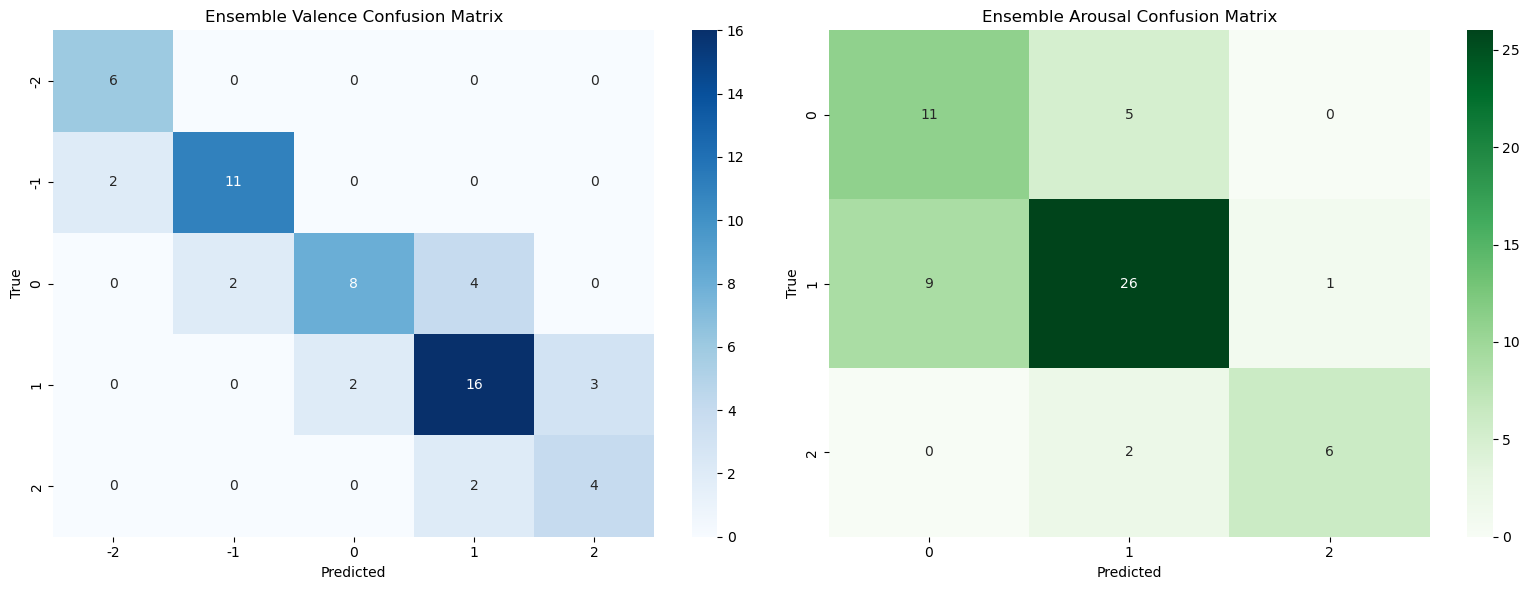

In [95]:
plot_ensemble_confusion_matrices(ens_val_pred, ens_aro_pred, true_val, true_aro, aggressive=True)